# XAI: Explainable AI

- 목적
  - UCI Breast Cancer 데이터를 로드하고 전처리 후 XGBoost 모델을 구축 및 평가
  - 교차검증(StratifiedKFold, KFold)과 하이퍼파라미터 탐색 기법(RandomizedSearchCV, Optuna)을 비교하여 최적 성능을 도출
  - SHAP을 활용하여 전역적·집단적·개별적 수준에서 해석력을 확보하고 도메인 지식과 연결
- 구현
  - 데이터 로드: UCI Breast Cancer 데이터셋
  - 데이터 전처리: 타겟(Diagnosis)을 이진화(M=1, B=0), StandardScaler로 범위 스케일링, 상관계수 0.9 이상인 중복 변수 제거
  - 모델 구축: xgboost.XGBClassifier
  - 모델 평가: 정확도, AUC, 분류리포트, 혼동행렬, feature importance
  - 교차검증: KFold, StratifiedKFold
  - 하이퍼파라미터 최적화: Random Search, Optuna TPE
  - 모델 해석 (SHAP)
    - Bar Summary Plot: 전역적 중요도(평균 |SHAP|)를 통해 주요 변수 확인
    - Beeswarm Plot: 변수 값 크기(빨강/파랑)와 방향성(+/−)에 따른 분포 해석
    - Force / Waterfall Plot: 3가지 개별 환자 샘플(예측 확률 극단/불확실, SHAP 영향력 최대, 도메인 특이 케이스)을 선택하여 모델이 어떤 요인 때문에 해당 예측을 내렸는지 설명

In [1]:
# Install the ucimlrepo package
!pip install ucimlrepo

# HPO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import time
import xgboost as xgb

# ==========================
# 1. Data Load
# ==========================

import pandas as pd
from ucimlrepo import fetch_ucirepo

def load_data():
    # fetch dataset
    breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

    # data (as pandas dataframes)
    X = breast_cancer_wisconsin_diagnostic.data.features
    y = breast_cancer_wisconsin_diagnostic.data.targets

    # Concatenate
    df = pd.concat([X, y], axis=1)

    print(f"Shape: {df.shape}")
    print(f"Info: {df.info()}")
    print(f"Samples: {df.head(5)}")
    print("Breast Cancer Dataset load")

    return df, X, y

# 1. 데이터 로드
df, X, y = load_data()

Shape: (569, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    floa

1. 데이터 구조
- 569개 샘플
- 30개 숫자형 특성과 1개 범주형 타깃(Diagnosis)

In [2]:
# ==========================
# 2. EDA
# ==========================

def eda_data(df, target_col=None):
    # target_col 자동 탐색
    if target_col is None:
        # 'y'가 있으면 우선 사용
        if 'y' in df.columns:
            target_col = 'y'
        else:
            # 마지막 컬럼을 기본 target으로 가정
            target_col = df.columns[-1]
        print(f"[INFO] Target column 자동 선택: {target_col}")

    # 데이터 타입
    print("데이터 타입:")
    print(df.dtypes)

    # 결측치 확인
    print("\n결측치 확인:")
    print(df.isnull().sum())

    # 타겟 변수 분포
    print(f"\n타겟 변수 분포 ({target_col}):")
    target_counts = df[target_col].value_counts()
    print(target_counts)
    print(f"비율: {target_counts / len(df) * 100}")

    # 숫자형 변수 기본 통계
    print("\n숫자형 변수 기본 통계:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(df[numeric_cols].describe())

    # 범주형 변수 고유값 개수 및 분포
    print("\n범주형 변수 고유값 개수:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"{col}: {df[col].nunique()}개 고유값")
        if df[col].nunique() <= 10:  # 고유값이 적으면 분포 출력
            print(df[col].value_counts().head())
        print()

# 2. 데이터 탐색
eda_data(df)

from sklearn.preprocessing import LabelEncoder, StandardScaler

# ==========================
# 3. Pre-processing
# ==========================

def preprocess_data(X, y, corr_threshold=0.9):
    X_processed = X.copy()

    # --------------------------
    # 1. 범주형 변수 인코딩
    # --------------------------
    categorical_columns = X_processed.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
        label_encoders[col] = le
        print(f"{col} 인코딩 완료: {len(le.classes_)}개 클래스")

    # --------------------------
    # 2. 타겟 변수 인코딩
    # --------------------------
    target_col = y.columns[0]

    if set(y[target_col].unique()) == {"yes", "no"}:
        y_processed = (y[target_col] == 'yes').astype(int)
    elif set(y[target_col].unique()) == {"B", "M"}:
        y_processed = (y[target_col] == 'M').astype(int)
    else:
        le = LabelEncoder()
        y_processed = le.fit_transform(y[target_col].astype(str))
        label_encoders[target_col] = le

    # 타깃 분포 출력
    target_dist = pd.Series(y_processed).value_counts(normalize=True) * 100
    print(f"타겟 분포(%): {target_dist.to_dict()}")

    # --------------------------
    # 3. 피처 스케일링
    # --------------------------
    scaler = StandardScaler()
    numeric_cols = X_processed.select_dtypes(include=[np.number]).columns
    X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])
    print(f"{len(numeric_cols)}개 숫자형 변수에 StandardScaler 적용")

    # --------------------------
    # 4. 피처 필터링 (상관관계 기반)
    # --------------------------
    corr_matrix = pd.DataFrame(X_processed, columns=numeric_cols).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 상관도가 높은 컬럼들 제거
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    if to_drop:
        print(f"상관계수 {corr_threshold} 이상인 {len(to_drop)}개 변수: {to_drop}")
        X_processed = X_processed.drop(columns=to_drop)

    return X_processed, y_processed, label_encoders


# 3. 데이터 전처리 실행
X_processed, y_processed, label_encoders = preprocess_data(X, y)


[INFO] Target column 자동 선택: Diagnosis
데이터 타입:
radius1               float64
texture1              float64
perimeter1            float64
area1                 float64
smoothness1           float64
compactness1          float64
concavity1            float64
concave_points1       float64
symmetry1             float64
fractal_dimension1    float64
radius2               float64
texture2              float64
perimeter2            float64
area2                 float64
smoothness2           float64
compactness2          float64
concavity2            float64
concave_points2       float64
symmetry2             float64
fractal_dimension2    float64
radius3               float64
texture3              float64
perimeter3            float64
area3                 float64
smoothness3           float64
compactness3          float64
concavity3            float64
concave_points3       float64
symmetry3             float64
fractal_dimension3    float64
Diagnosis              object
dtype: object

결측치 확인:
r

2. EDA & 3. 데이터 전처리
- 결측치 확인
  - 존재하지 않으므로 결측치 전처리 불필요

- 타깃 변수 분포 (불균형 여부)
  - B(양성, Benign) 357건 (62.7%), M(악성, Malignant) 212건 (37.3%)
  - 6:4의 클래스 불균형이 존재하므로 단순 정확도(Accuracy)만 보면 불균형에 의해 성능이 과대평가될 수 있으므로 재현율(Recall), 정밀도(Precision), F1, AUC 등 불균형에 강한 지표로 성능 평가하기.

- 숫자형 변수 분포
  - 변수마다 범위 차이가 매우 크다. 예를들어 area1은 최소 143 ~ 최대 2501 인데 smoothness1은 평균 0.096, 최대 0.16이다. 같은 모델 입력에 넣으면 큰 값이 작은 값을 묵살할수있다.
  - 30개의 숫자형 변수에 StandardScaler를 적용해서 평균 0, 분산 1의 분포로 변환.

- 상관관계 기반 피처 제거
  - 피쳐가 30개로 좀 많응편인데 피처 수가 줄어들면서 해석력이 향상되고 과적합 위험이 완화된다. 서로 강하게 상관된 피처들은 대표성 있는 하나만 남기고 나머지는 제거하는 게 좋으므로 상관계수가 높은 피쳐는 제거하기.
  - 상관계수 0.9 이상인 피처 10개 제거: ['perimeter1', 'area1', 'concave_points1', 'perimeter2', 'area2', 'radius3', 'texture3', 'perimeter3', 'area3', 'concave_points3']

- 해석 가능성 기준 피쳐 유지
  - 의료 데이터라는 특성상, 의사가 직관적으로 이해할 수 있는 변수를 남기는 게 중요하므로 smoothness, symmetry 같은 형태학적 지표는 모델 해석에 유리하므로 유지 가치가 있다. 제거하지 말기.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb

# ==========================
# 4. Model Build & Evaluation
# ==========================

def build_and_evaluate_model(X, y):
    """XGBoost 모델 구축 및 평가"""
    print("\n=== XGBoost 모델 구축 및 평가 ===")

    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"훈련 데이터: {X_train.shape}")
    print(f"테스트 데이터: {X_test.shape}")

    # 특성 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # XGBoost 모델 정의
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        early_stopping_rounds=5,
        eval_metric='logloss'
    )

    # 모델 학습
    print("XGBoost Learning...")
    xgb_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )

    # 예측
    y_pred = xgb_model.predict(X_test_scaled)
    y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

    # 평가 지표
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"\n정확도(Accuracy): {accuracy:.4f}")
    print(f"AUC 점수: {auc_score:.4f}")

    print("\n분류 리포트 (Precision / Recall / F1):")
    print(classification_report(y_test, y_pred))

    print("\n혼동 행렬:")
    print(confusion_matrix(y_test, y_pred))

    # 특성 중요도
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n상위 10개 중요한 특성:")
    print(feature_importance.head(10))

    return xgb_model, scaler, feature_importance


# 4. 모델 구축 및 평가 실행
model, scaler, feature_importance = build_and_evaluate_model(X_processed, y_processed)



=== XGBoost 모델 구축 및 평가 ===
훈련 데이터: (455, 20)
테스트 데이터: (114, 20)
XGBoost Learning...

정확도(Accuracy): 0.9474
AUC 점수: 0.9864

분류 리포트 (Precision / Recall / F1):
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        72
           1       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114


혼동 행렬:
[[71  1]
 [ 5 37]]

상위 10개 중요한 특성:
         feature  importance
4     concavity1    0.399604
16  compactness3    0.171917
0        radius1    0.122538
15   smoothness3    0.058100
17    concavity3    0.054556
10  compactness2    0.025185
5      symmetry1    0.021820
1       texture1    0.020361
18     symmetry3    0.018894
2    smoothness1    0.016591


4. 모델 구축 및 평가 실행
- 정확도 (Accuracy = 0.9474)
  - 모델이 꽤 잘 맞히고 있다 (정확도 95%).
  - 정확도는 클래스 불균형 상황에서 높게나오기쉬워서 확인해야하는데 이 데이터셋은 불균형이 심하지 않아(0 클래스 72, 1 클래스 42) 정확도가 어느 정도 신뢰할만하다고 생각된다.

- AUC (0.9864)
  - AUC가 0.98이라는 것은 특정 임계값에서만 잘 작동하는 게 아니라 전반적으로 좋은 분류 성능을 갖고 있음을 의미한다. 특히 불균형 데이터셋에서는 AUC가 더 안정적인 지표인데 이 데이터셋은 약간의 불균형 데이터셋인데 높은 가까운 구분력을 보여준다.

- 분류 리포트
  - 클래스 0: Precision 0.93, Recall 0.99 -> 정상 환자를 거의 다 잡아내고, 일부를 암으로 잘못 분류하는 경우가 극히 적음.
  - 클래스 1: Precision 0.97, Recall 0.88 -> 암으로 예측했을 때 대부분 맞지만, 실제 암 환자 중 일부(약 12%)를 놓쳤음.
  - F1-score: 클래스 0은 0.96, 클래스 1은 0.93 -> 두 클래스 모두 균형 잡힌 성능이지만, 클래스 1에서 recall이 떨어짐.
  - 모델은 정상 환자(클래스 0)에 대해 매우 민감하게 반응하지만 암 환자(클래스 1) 중 일부를 놓치고 있음 의료 분야에서는 Recall(재현율) 이 더 중요할 수 있으므로 threshold 조정이나 클래스 가중치 보정 같은 방법으로 보완이 필요
- 혼동행렬
[[71  1]
 [ 5 37]]
  - 실제 0(정상) 중 71명을 맞히고 1명을 암으로 잘못 분류함 -> 거짓양성(FP) 거의 없음.
  - 실제 1(암) 중 37명을 맞히고 5명을 정상으로 잘못 분류함 -> 거짓음성(FN)이 존재.
  - 의료도메인은 과잉진료가 차라리 낫다. 암 환자를 정상으로 예측한 경우 (FN)가 더 문제이므로 recall 지표인 이 부분이 보완이 필요하다.

- 특성 중요도
  - concavity1이 40% 비중으로 가장 중요한 변수이며, compactness3, radius1 등이 뒤를 잇습니다.
  - 실제 유방암 데이터 문헌에서 일관되게 보고되는 중요한 특징들과 일치할 경우 모델이 중요한 변수를 잘 포착하고 있다고 볼수있는데 도메인 지식이 부족하여 잘 모르겠음. 

In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler

# ==========================
# 5. Cross-Validation Strategies
# ==========================

def compare_cv_strategies(X, y):
    """다양한 CV 전략 비교"""
    print("\n=== Cross-Validation 전략 비교 ===")

    # 스케일링 (CV 안정성을 위해)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 모델 정의
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )

    # CV 전략들
    cv_strategies = {
        'KFold (5-fold)': KFold(n_splits=5, shuffle=True, random_state=42),
        'StratifiedKFold (5-fold)': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        'StratifiedKFold (20-fold)': StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    }

    results = {}
    for name, cv_strategy in cv_strategies.items():
        scores = cross_val_score(
            xgb_model, X_scaled, y,
            cv=cv_strategy, scoring='roc_auc', n_jobs=-1
        )
        results[name] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
        print(f"{name}: 평균 AUC={scores.mean():.4f}, 표준편차={scores.std():.4f}, 95% CI ≈ ±{scores.std()*2:.4f}")

    return results


# 5. 교차검증 전략 비교 실행
results = compare_cv_strategies(X_processed, y_processed)



=== Cross-Validation 전략 비교 ===
KFold (5-fold): 평균 AUC=0.9880, 표준편차=0.0106, 95% CI ≈ ±0.0211
StratifiedKFold (5-fold): 평균 AUC=0.9902, 표준편차=0.0058, 95% CI ≈ ±0.0116
StratifiedKFold (20-fold): 평균 AUC=0.9912, 표준편차=0.0151, 95% CI ≈ ±0.0302


5. 교차검증 전략 비교 실행
- KFold
  - 사용된 데이터셋 클래스 비율이 B: 62.7%, M: 37.3%로 약간 불균형이 있기 때문에 Kfold를 사용하면 어떤 Fold에는 M이 적게 들어가고 어떤 Fold에는 많아질 수 있다. 
  - 이러면 Fold 간 성능 편차가 커지거나, 특정 Fold에서 모델이 과소평가/과대평가될 가능성이 있다
- StratifiedKFold
  - StratifiedKFold는 클래스 비율을 유지해서 나누기 때문에 불균형 셋이어도 각 Fold가 전체 분포를 잘 대표한다 
  - 실제로 결과 평균 성능 AUC도 아주조금 높고 (0.98 -> 0.99, 0.99), 표준편차가 5 fold에선 절반 수준으로 줄었다 (0.01 -> 0.005, 0.01)
  - 결론1: 현재와같은 불균형 데이터일 때는 StratifiedKFold가 더 공정하고 안정적인 평가를 제공하므로 이번 데이터셋에서도 적합한것으로 생각된다
- 5-fold vs. 20-fold
  - AUC는 비슷하고(0.99, 0.99) 표준편차는 2배 차이난다(0.005, 0.01). CI 폭은 20 fold가 더 넓다(0.01, 0.03)
  - 5 fold는 데이터셋을 크게 나누고 20 fold로 늘어나면 한 Fold당 검증 데이터가 적어진다. 데이터가 적다 보니 Fold별 AUC 변동이 커진다.
  - 20 fold에서 평균적으로 조금 정확해보이지만(AUC) 결과 불안정성이 크고(표준편차) 실제 성능이 0.96~1.02 범위까지 널뛰기할 수 있다(CI 폭).
  - 결론2: 데이터가 많은 경우엔 20-fold도 의미 있지만 현재 데이터셋(569개 샘플)에서는 5-fold가 더 합리적으로 생각된다.
- 모델 평가
  - 모델이 악성(M)과 양성(B)을 잘 구분하며(AUC=0.99) 
  - 모델이 특정 데이터 샘플에 과도하게 의존하지 않아서 일관성 있는 결과를 내지만(표준편차 0.0058: 매우작음)
  - AUC가 높은게 실제 배포 상황에서는 데이터 편향이나 작은 잡음에도 민감할 수 있다 즉 훈련 데이터 분포와 다른 새로운 데이터에서 성능이 유지되는지확인해야한다.

In [7]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
import optuna

# ==========================
# 6. HPO (Random Search - XGBoost)
# ==========================
def random_search_tuning_xgb(X, y):
    print("\n=== 하이퍼파라미터 튜닝 (RandomizedSearchCV - XGBoost) ===")
    
    param_distributions = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }

    xgb_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )

    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=30,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    random_search.fit(X_scaled, y)

    print(f"최적 파라미터: {random_search.best_params_}")
    print(f"최적 CV AUC 점수: {random_search.best_score_:.4f}")

    return random_search.best_estimator_, scaler, random_search


# 실행
best_estimator_random, scaler_random, random_search = random_search_tuning_xgb(X_processed, y_processed)


# ==========================
# 7. HPO (Optuna - TPE - XGBoost)
# ==========================
def optuna_search_tuning_xgb(X, y, n_trials=30):
    print("\n=== 하이퍼파라미터 튜닝 (Optuna - TPE - XGBoost) ===")

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'random_state': 42,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'use_label_encoder': False
        }
        model = XGBClassifier(**params)
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        auc = roc_auc_score(y_val, y_pred_proba)
        return auc

    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    print(f"최적 파라미터: {study.best_params}")
    print(f"최적 AUC 점수: {study.best_value:.4f}")

    return study.best_params, study


# 실행
best_params_optuna, study = optuna_search_tuning_xgb(X_processed, y_processed, n_trials=30)




=== 하이퍼파라미터 튜닝 (RandomizedSearchCV - XGBoost) ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:35:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1757347895952/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:35:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1757347895952/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:35:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1757347895952/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:35:27] WARNI

최적 파라미터: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
최적 CV AUC 점수: 0.9936

=== 하이퍼파라미터 튜닝 (Optuna - TPE - XGBoost) ===


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:35:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1757347895952/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-21 06:35:30,653] Trial 2 finished with value: 0.990079365079365 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302}. Best is trial 2 with value: 0.990079365079365.
/opt/anaconda3/envs/skala/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:35:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1757347895952/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-21 06:35:30,738] Trial 3 finished with value: 0.9907407407407408 and parameters: {'n_estimators': 96, 'max_

최적 파라미터: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.019613277466224713, 'subsample': 0.8231012514165693, 'colsample_bytree': 0.9428736755059344}
최적 AUC 점수: 0.9924


6 & 7. 하이퍼파라미터 튜닝 (RandomizedSearchCV vs Optuna)

- 분석 대상인 하이퍼파라미터
  - n_estimators (트리 개수): 크면 학습을 오래 시킴, 성능을 높일 수 있음, overfitting
  - max_depth (트리 깊이): 깊으면 데이터의 세부 패턴까지 학습해 overfitting
  - learning_rate (학습률): 크면 빠르게 학습하지만 최적점을 지나쳐 버릴 수 있어 overfitting. 작으면 한 스텝씩 조심스럽게 학습해 일반화 성능은 좋아지지만 많은 트리 n_estimators가 필요할수있음.
  - subsample (샘플 비율): 크면 variance가 크고 overfitting. 
  - colsample_bytree (특성 샘플링 비율): 1.0이면 모든 피처를 쓰고 낮추면 랜덤성을 주므로 모델 다양성을 높여 overfitting 완화.

- RandomizedSearchCV 결과 및 해석
  - n_estimators = 200 (중간수치 선택)
  - max_depth = 6 (중간수치 선택)
  - learning_rate = 0.2 ([0.01, 0.05, 0.1, 0.2] 중 0.2 -> 빠르게 학습)
  - subsample = 0.7 ([0.7, 0.8, 0.9, 1.0] 중 0.7 -> 랜덤성 부여해서 과적합 억제)
  - colsample_bytree = 1.0 ([0.7, 0.8, 0.9, 1.0] 중 1.0 -> 모든 특성을 사용
  - 해석: Random Search에서는 학습률을 크게 두고 빠른 수렴을 유도하면서, 트리 깊이를 6으로 제한해 과적합을 막았다. 또 데이터 샘플은 70%만 써서 안정성을 확보했고 피처 수는 과도하지않아 전부 사용했다. 
  - 성능: CV AUC = 0.9936 (높은 성능)

- Optuna 결과 및 해석
  - n_estimators = 233 (50~300중 233 -> random search보다 조금 더 많음 -> 작은 learning_rate 보완)
  - max_depth = 8 (3~10중 8 -> random search보다 깊은 트리 -> 복잡한 패턴까지 학습)
  - learning_rate ≈ 0.0196 (0.01~0.3 중 0.0196 -> 아주 작은 값 -> 신중하게 학습, 대신 많은 트리가 필요)
  - subsample ≈ 0.823 (0.7~1.0 중 0.823 -> 나름 랜덤성 부여로 과적합 방지)
  - colsample_bytree ≈ 0.943 (0.7~1.0 중 0.943 -> 전체 피처의 94%만 사용해서 random search에 비해 약간 랜덤성 추가)
  - 해석: Optuna는 random search에 비해 학습률을 매우 작게 두고(0.2 -> 0.02) 트리 깊이를 늘려(6->8) 복잡한 구조를 학습함 트리 개수는 비슷하지만 200에서 233개로 늘렸고, subsample도 random보다는 높지만 낮춰서 조절하였고 colsample을 낮춰서 샘플 샘플링과 피쳐 샘플링으로 overfitting을 방지했다. Optuna는 학습률을 작게 두고 천천히 정밀하게 더 복잡한 모델을 만들었다.
  - 성능: CV AUC = 0.9924 (Random Search보다 살짝 낮지만 충분히 높기도 하고 더 안정적이고 일반화 지향적인 조합을 찾아냈다고 해석할수있다)

- Random Search와 Optuna의 성질과 결과 해석
  - Random Search
    - 무작위로 뽑아 다양한 지점을 빠르게 탐색. 계산 효율적이고 좋은 지점을 “운 좋게” 발견할 수 있음.
    - 결과: 큰 learning_rate + 얕은 깊이 -> 빠르고 간단한 학습을 설계
  - Optuna (TPE)
    - 이미 탐색한 결과를 바탕으로 “좋아 보이는 구간”을 집중 탐색. 더 정교하고 확률적 탐색.
    - 결과: 작은 learning_rate + 깊은 트리 -> 느리지만 정밀한 학습을 설계
  - 결과 해석
    - 성능 수치로는 Random Search가 조금 더 높아서(0.9936 vs 0.9924) 최적 파라미터로는 Random search가 선택되었다
    - AUC는 둘다 높기도 하고 Optuna의 특성상 Optuna 결과가 일반화 성능에 더 유리할 가능성도 있다고 생각됨.

- 실제 현장에서?
  - Random Search
    - 빠른 학습률(0.2)과 비교적 단순한 구조(max_depth=6, n_estimators=200)로도 AUC 0.9936이라는 매우 높은 성능을 보였기 때문에 의료 현장에서 빠른 예측이 필요할 때 유리할 것으로 생각됨
    - 검진센터나 실시간 판독 지원 시 빠르고 계산 자원이 덜 드는 Random Search 모델이 적합할수있다
  - Optuna
    - 매우 작은 학습률(0.02)과 깊은 트리(max_depth=8, n_estimators=233)를 사용하여, 더 세밀하게 데이터를 학습했고 이는 재현율(Recall)을 더 확보해 악성 환자를 놓치지 않는 방향으로 일반화 성능을 강화했을 가능성이 있음 
    - 의료 진단에서는 한 명의 악성 환자라도 놓치지 않는 것(민감도/Recall 우선) 이 중요하기 때문에 진단 보조, 재검 필요성 판단과 같은 실제 임상 적용 시 Optuna 모델이 더 신뢰할 만하다고 생각된다.

# XAI

In [9]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.9/555.9 kB 1.4 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]1/2 [shap]



=== SHAP 해석 (XGBoost (RandomSearchCV)) ===


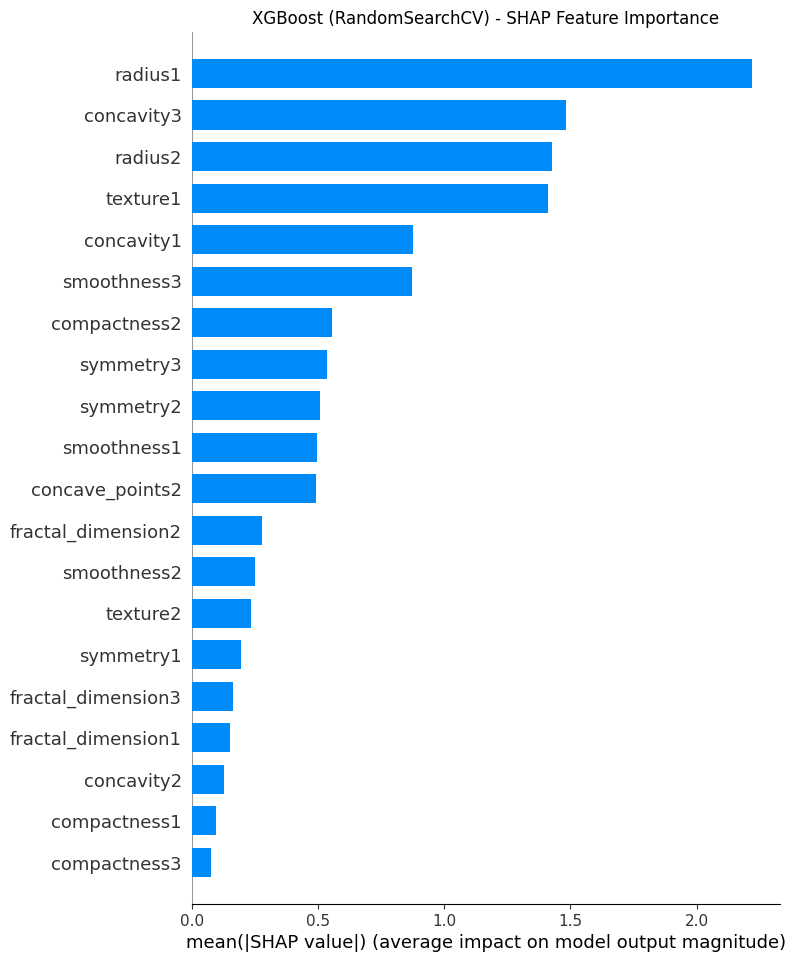

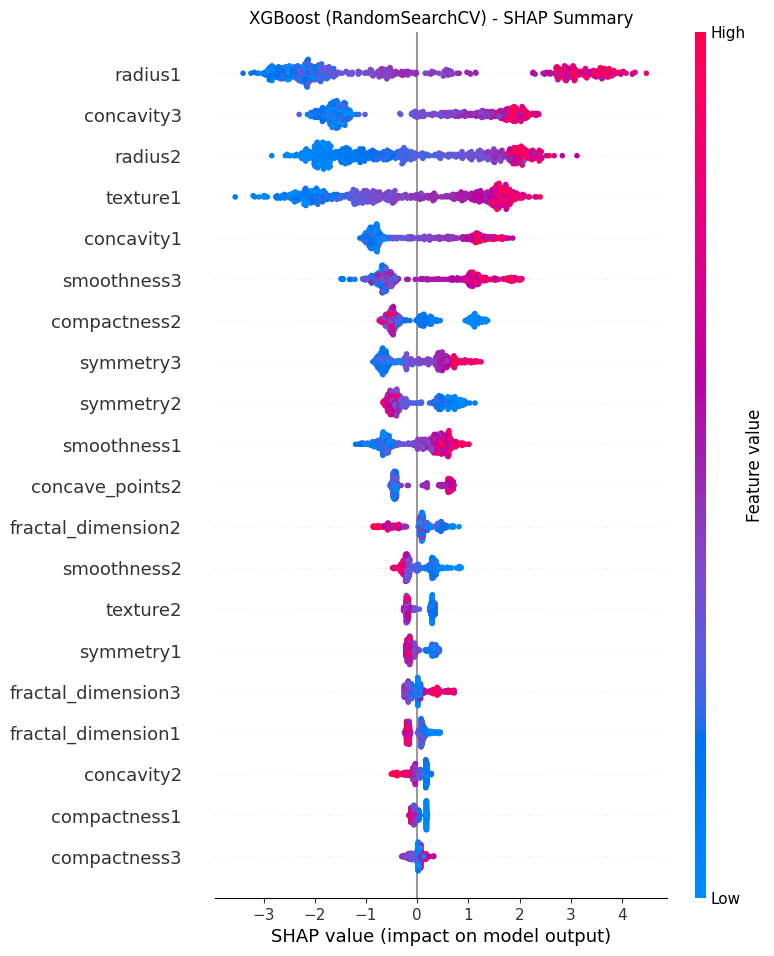

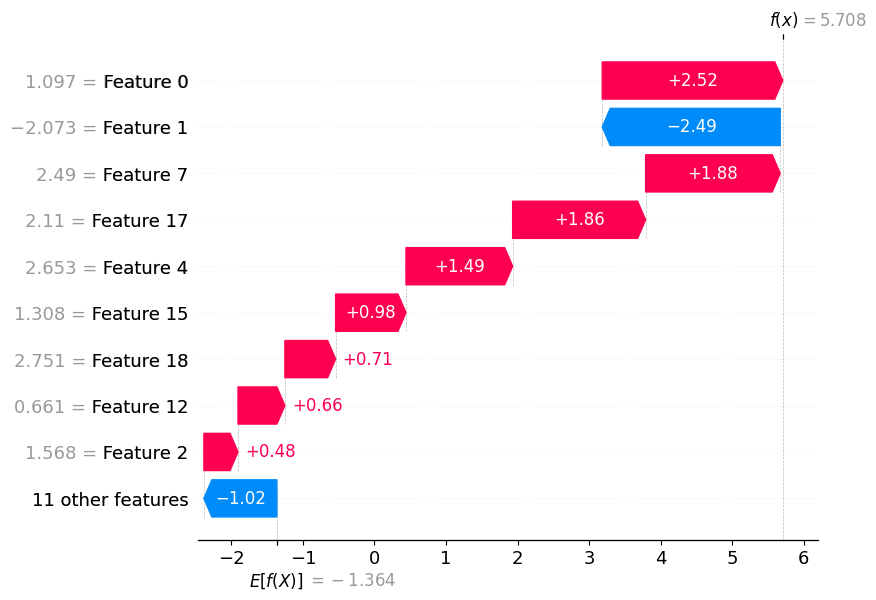


=== SHAP 해석 (XGBoost (Optuna TPE)) ===


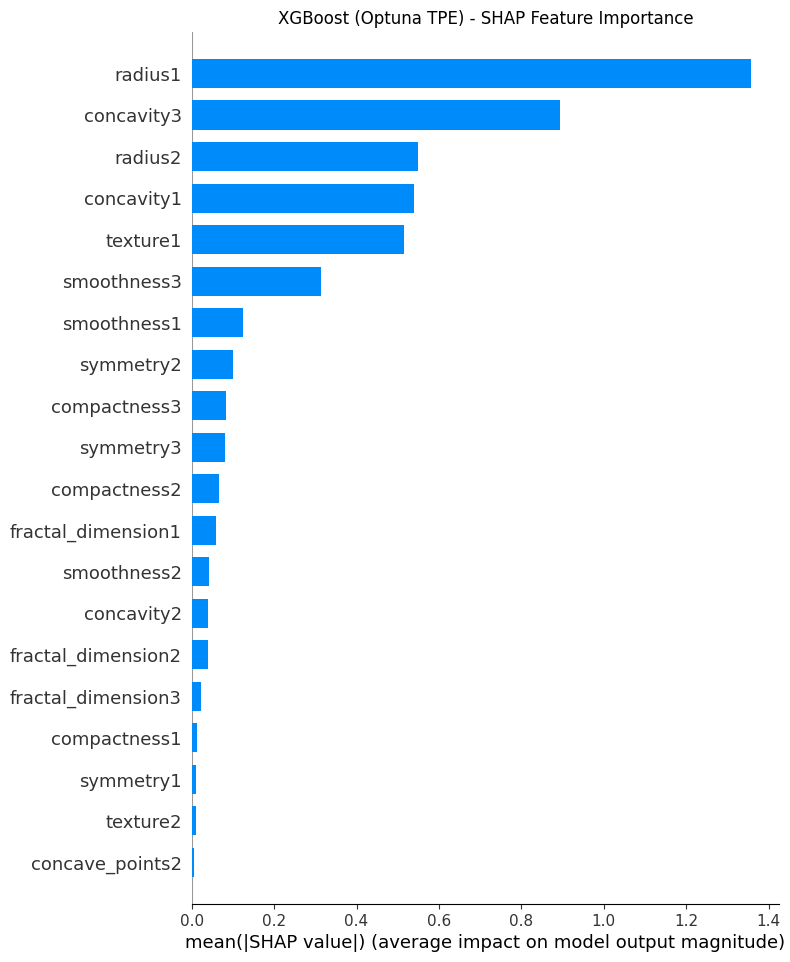

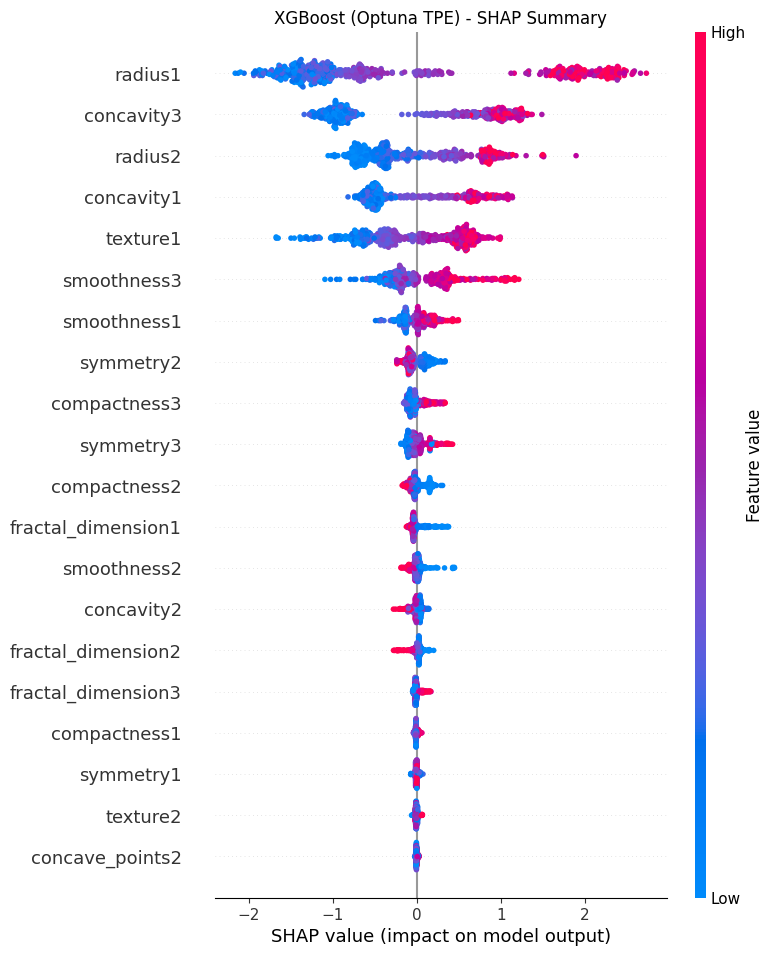

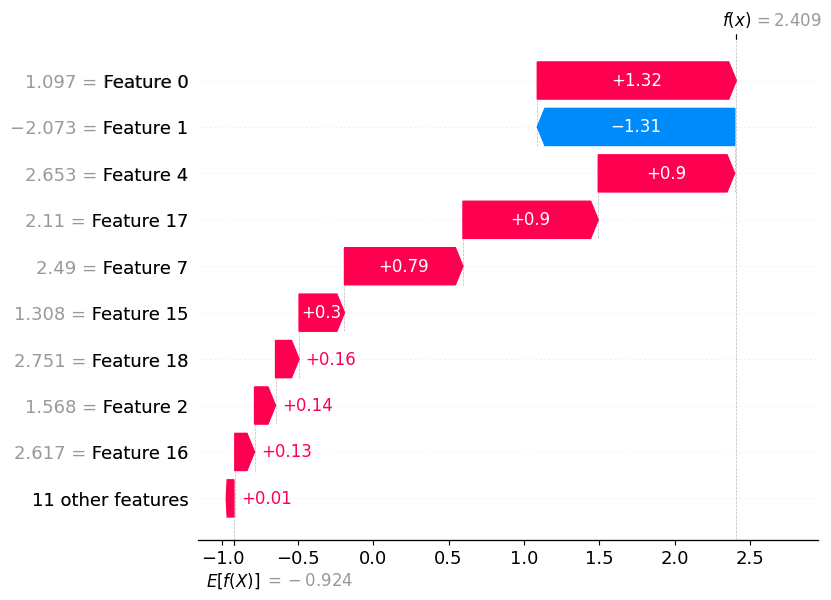

In [ ]:
import shap
import matplotlib.pyplot as plt

# ==========================
# 8. SHAP 기반 해석 (XGBoost)
# ==========================
def shap_explain(model, X, model_name="Model"):
    print(f"\n=== SHAP 해석 ({model_name}) ===")

    # 스케일링 적용 (RandomSearch/Optuna에서 이미 StandardScaler 사용했으므로 다시 맞춤)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # SHAP explainer 생성
    explainer = shap.Explainer(model, X_scaled)
    shap_values = explainer(X_scaled)

    # 전역 특성 중요도
    plt.figure()
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title(f"{model_name} - SHAP Feature Importance")
    plt.show()

    # 세부 분포 플롯
    plt.figure()
    shap.summary_plot(shap_values, X, show=False)
    plt.title(f"{model_name} - SHAP Summary")
    plt.show()

    # 임의의 샘플 하나에 대한 로컬 설명
    sample_idx = 0
    shap.plots.waterfall(shap_values[sample_idx], max_display=10)

    return shap_values

# RandomSearch로 찾은 모델 해석
shap_values_random = shap_explain(best_estimator_random, X_processed, model_name="XGBoost (RandomSearchCV)")

# Optuna로 찾은 최적 파라미터 기반 모델 생성 & 해석
optuna_model = XGBClassifier(**best_params_optuna)
optuna_model.fit(StandardScaler().fit_transform(X_processed), y_processed)
shap_values_optuna = shap_explain(optuna_model, X_processed, model_name="XGBoost (Optuna TPE)")


In [ ]:
import numpy as np
import pandas as pd

def print_shap_inputs(shap_values, X, sample_idx=0, top_n=10):
    print("\n=== [1] Bar Plot Input: 전역 중요도 (평균 |SHAP| 값) ===")
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    bar_importance = pd.Series(mean_abs_shap, index=X.columns).sort_values(ascending=False)
    print(bar_importance.head(top_n))

    print("\n=== [2] Beeswarm Plot Input: 샘플별 SHAP 값과 원본 Feature 값 ===")
    # shap_values.values = (n_samples, n_features)
    print(f"SHAP values shape: {shap_values.values.shape}")
    print(f"X shape: {X.shape}")
    print("예시 (앞 5행, 앞 5개 피처):")
    print(pd.DataFrame(shap_values.values[:5, :5], 
                       columns=X.columns[:5]))
    print("해당 샘플들의 원본 Feature 값 (앞 5행, 앞 5개 피처):")
    print(X.iloc[:5, :5])

    print("\n=== [3] Waterfall Plot Input: 특정 샘플(Local Explanation) ===")
    base_value = shap_values[sample_idx].base_values
    shap_vals_sample = shap_values[sample_idx].values
    feature_vals_sample = X.iloc[sample_idx]

    df_local = pd.DataFrame({
        "feature": X.columns,
        "feature_value": feature_vals_sample.values,
        "shap_value": shap_vals_sample
    }).sort_values(by="shap_value", key=np.abs, ascending=False)

    print(f"Base value (bias): {base_value}")
    print(f"모델 최종 예측값: {base_value + shap_vals_sample.sum()}")
    print("상위 기여 피처:")
    print(df_local.head(top_n))


# ✅ RandomSearch 모델 SHAP input 출력
print_shap_inputs(shap_values_random, X_processed, sample_idx=0, top_n=10)

# ✅ Optuna 모델 SHAP input 출력
print_shap_inputs(shap_values_optuna, X_processed, sample_idx=0, top_n=10)


=== [1] Bar Plot Input: 전역 중요도 (평균 |SHAP| 값) ===
radius1         2.219144
concavity3      1.483260
radius2         1.428291
texture1        1.412490
concavity1      0.875924
smoothness3     0.873013
compactness2    0.557335
symmetry3       0.533878
symmetry2       0.508226
smoothness1     0.495863
dtype: float64

=== [2] Beeswarm Plot Input: 샘플별 SHAP 값과 원본 Feature 값 ===
SHAP values shape: (569, 20)
X shape: (569, 20)
예시 (앞 5행, 앞 5개 피처):
    radius1  texture1  smoothness1  compactness1  concavity1
0  2.523605 -2.487796     0.477047     -0.120979    1.491277
1  3.779855 -0.517787    -0.599387     -0.027253    0.143385
2  2.919261  1.184097     0.620082     -0.123815    1.272350
3 -2.716401  0.788674     0.889278     -0.116620    1.376978
4  3.189101 -2.536431     0.579587     -0.123815    1.475474
해당 샘플들의 원본 Feature 값 (앞 5행, 앞 5개 피처):
    radius1  texture1  smoothness1  compactness1  concavity1
0  1.097064 -2.073335     1.568466      3.283515    2.652874
1  1.829821 -0.353632    -0.8269

8. SHAP 기반 해석 (XGBoost)

- 8-1. Bar Summary Plot
  - 플롯으로 확인 가능한것: 전역적 중요도 크기
  - 봐야하는것: 막대 길이
    - 막대 길이: 길수록 전체 모델 예측에서 해당 변수가 차지하는 중요도가 크다.

  - RandomSearchCV 결과
    - radius1 (2.219)와 concavity3 (1.483), radius2 (1.428), texture1 (1.412)가 가장 길다 → 전역적으로 중요한 변수임을 의미.
    - compactness2 (0.557), symmetry3 (0.534), smoothness1 (0.496)은 중간 정도 기여.
  - Optuna TPE 결과
    - radius1 (1.357)와 concavity3 (0.895), radius2 (0.550), concavity1 (0.540), texture1 (0.516)이 상위 그룹.
    - 나머지 변수(smoothness3 0.315 이하)는 기여도가 급격히 낮음.
  - 해석
    - 전역적으로 보면 두 모델 모두 radius1과 concavity 관련 변수들을 가장 중요한 특징으로 본다.
    - 차이는 RandomSearchCV는 texture1도 radius와 비슷한 수준으로 중요하게 평가했고, Optuna TPE에서는 concavity1이 더 높게 올라왔다
    - 따라서 Optuna는 형태적 지표(concavity)를 더 강조한 반면, RandomSearch는 크기 지표(radius, texture)를 좀 더 고르게 반영했다.

- 8-2. Beeswarm Plot
  - 플롯으로 확인 가능한것: 전역 + 값의 방향성/분포
  - 봐야하는것: 막대 길이, 방향성, 색깔
    - 막대 길이: 분포가 넓을수록 샘플별로 변수 효과가 다양하다.
    - 방향성: +일수록 예측값을 올린다, -일수록 예측값을 낮춘다.
    - 색깔: 빨강 = 변수 값이 크다, 파랑 = 변수 값이 작다.
  - RandomSearchCV 결과
    - radius1: 빨강(값 큼)일 때 오른쪽(+), 파랑(값 작음)일 때 왼쪽(-) → radius가 크면 악성 확률↑, 작으면↓.
    - concavity3: 값이 클수록(+ 방향) 악성 확률↑.
    - texture1: 값이 큰 샘플은 오른쪽(↑), 작은 샘플은 왼쪽(↓).
    - 전반적으로 주요 변수들은 선형적으로 값이 클수록 악성 확률을 올리는 패턴을 보이는것으로 생각됨
  - Optuna TPE 결과
    - radius1, concavity3에서 동일한 패턴 확인됨.
    - 다만, Optuna에서는 concavity1 기여도가 texture1보다 크며, 샘플별 변동 폭도 상대적으로 큼.
    - 즉, Optuna는 concavity 기반 분포 차이를 더 민감하게 반영.
  - 해석
    - RandomSearchCV는 radius(크기)와 concavity(형태)가 비슷하게 작동하는 균형적 구조.
    - Optuna는 concavity 변수의 분포 차이에 따른 영향을 더 집중적으로 반영.
    - 두 모델 모두 공통적으로
      - 빨강+양수 = 변수 값이 크면 악성 확률이 높다고 말함.
      - 파랑+음수 = 값이 작으면 악성 확률이 낮아진다고 말함.

- 8-3. Force / Waterfall Plot
  - 플롯으로 확인 가능한 것: 개별 사례 해석
  - 봐야하는것: 막대 길이, 방향성
    - 막대 길이: 길수록 해당 샘플의 예측에 기여한 정도가 크다.
    - 방향성: +일수록 예측값을 올리는 요인, -일수록 낮추는 요인.
  - RandomSearchCV 결과 (샘플 0번)
    - radius1=1.097 → shap=+2.52, concavity1=2.65 → +1.49, concavity3=2.11 → +1.86 → 이 샘플을 악성 쪽으로 강하게 밀어냄.
    - 반대로 texture1=-2.07 → -2.48은 양성 방향으로 억제.
    - 최종 예측값 = 5.71 → 악성 확률 높음.
  - Optuna TPE 결과 (샘플 0번)
    - radius1=1.097 → +1.32, concavity1=2.65 → +0.90, concavity3=2.11 → +0.90 → 역시 악성 쪽 기여.
    - texture1=-2.07 → -1.31은 양성 쪽으로 억제.
    - 최종 예측값 = 2.41 → RandomSearch보다 기여 크기는 낮지만 여전히 악성 방향.
  - 해석
    - 두 모델 모두 동일 샘플에서 radius와 concavity가 악성 위험도를 높이고, texture가 반대로 낮추는 역할을 함을 보여줌.
    - RandomSearch는 전체 SHAP 기여 폭이 더 크고 예측 확신도 강함.
    - Optuna는 radius/concavity 기여도는 유지하되 전체 기여값을 줄여 보다 보수적인 예측을 함.

In [ ]:
# ==========================
# 9. SHAP 기반 해석 (XGBoost) - 추가 분석
# ==========================

import numpy as np
import pandas as pd

# ---- 1. 예측 확률 기준 ----
y_proba = best_estimator_random.predict_proba(X_processed)[:, 1]
important_idx_prob = np.argmax(y_proba)   # 악성 확률 가장 높은 샘플
uncertain_idx_prob = np.argmin(np.abs(y_proba - 0.5))  # 불확실한 샘플 (0.5 근처)

print("✅ 예측 확률 기준 샘플:")
print(f"- 가장 악성일 확률이 높은 샘플 index: {important_idx_prob}, 확률={y_proba[important_idx_prob]:.4f}")
print(f"- 가장 불확실한 샘플 index: {uncertain_idx_prob}, 확률={y_proba[uncertain_idx_prob]:.4f}")


# ---- 2. SHAP 기여 강도 기준 ----
shap_strength = np.abs(shap_values_random.values).sum(axis=1)
important_idx_shap = np.argmax(shap_strength)

print("\n✅ SHAP 기여 강도 기준 샘플:")
print(f"- SHAP 영향력이 가장 큰 샘플 index: {important_idx_shap}, 총합={shap_strength[important_idx_shap]:.4f}")


# ---- 3. 도메인 특이 케이스 기준 ----
small_radius_idx = np.argmin(X_processed['radius1'])

print("\n✅ 도메인 특이 케이스 기준 샘플:")
print(f"- radius1이 가장 작은 샘플 index: {small_radius_idx}, 값={X_processed.loc[small_radius_idx, 'radius1']:.4f}")


✅ 예측 확률 기준 샘플:
- 가장 악성일 확률이 높은 샘플 index: 236, 확률=1.0000
- 가장 불확실한 샘플 index: 297, 확률=0.8534

✅ SHAP 기여 강도 기준 샘플:
- SHAP 영향력이 가장 큰 샘플 index: 0, 총합=15.8481

✅ 도메인 특이 케이스 기준 샘플:
- radius1이 가장 작은 샘플 index: 101, 값=-2.0296


9. SHAP 기반 해석 (XGBoost) - 추가 분석

- 딘순히 샘플 0번을 해석했었는데, 개별 사례 해석할 샘플을 3가지 기준으로 선택해보기.
- 예측 확률 기준
  - 척도: 모델이 출력한 predict_proba 값(악성일 확률)
  - 선택: 모델이 가장 확신 있게 악성이라고 본 샘플과, 모델이 가장 불확실하게 분류한 샘플
  - 선택된 샘플:
    - index 236: 예측 확률 1.0000 → 모델이 거의 100% 악성으로 판단. → 전형적인 악성 특징을 강하게 가진 환자 케이스일 가능성.
    - index 297: 예측 확률 0.8534 → 0.5보다는 높지만 애매한 수준. → 경계선적 특성을 가진 케이스로, 모델이 불확실해 함.
- SHAP 기여 강도 기준
  - 척도: 각 샘플별 SHAP 값 절댓값의 합(∑|SHAP|) → 특정 샘플에서 모델이 얼마나 강하게 반응했는지를 나타냄
  - 선택: SHAP 영향력이 가장 큰 샘플
  - 선택된 샘플:
    - index 0: SHAP 총합 15.8481 → 여러 피처들이 예측에 강하게 작용한 대표적 사례. → 모델 의사결정이 가장 뚜렷하게 드러나는 샘플로 해석 가치가 높음.
- 도메인 특이 케이스 기준
  - 척도: radius1 값(종양 반경, 크기)을 기준으로 선택 → 가장 작은 반경을 가진 사례
  - 선택: 반경이 가장 작은 샘플
  - 선택된 샘플:
    - index 101: radius1 = -2.0296 (스케일링 값, 실제로는 매우 작은 반경) → 작은 종양임에도 악성/양성을 어떻게 판단했는지 확인할 수 있는 케이스. → 임상적으로도 “작지만 의미 있는 종양”을 설명하는 데 활용 가능.



=== [Local Explanation: Plot Only] XGBoost (RandomSearchCV) | 샘플 index=236 ===


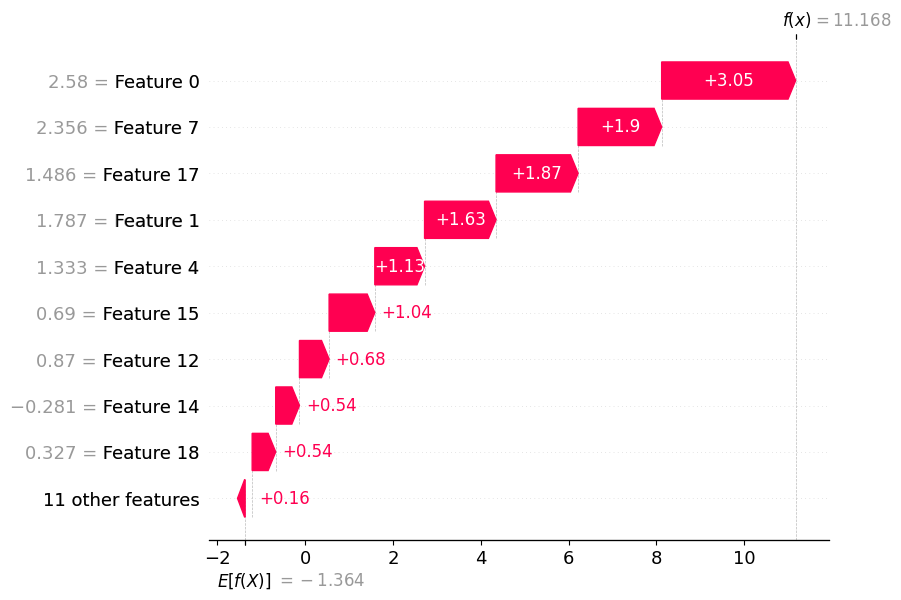


=== [Local Explanation: Plot Only] XGBoost (RandomSearchCV) | 샘플 index=297 ===


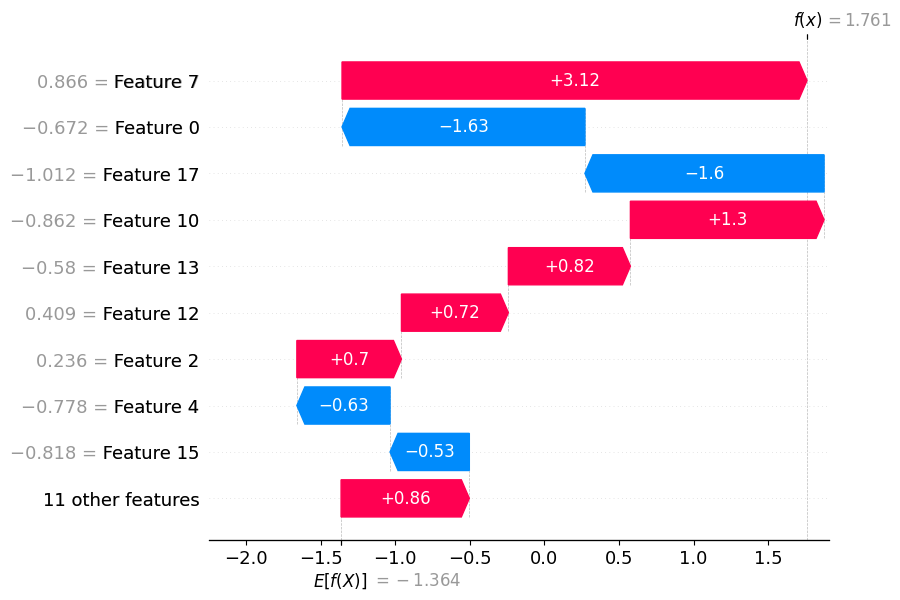


=== [Local Explanation: Plot Only] XGBoost (RandomSearchCV) | 샘플 index=0 ===


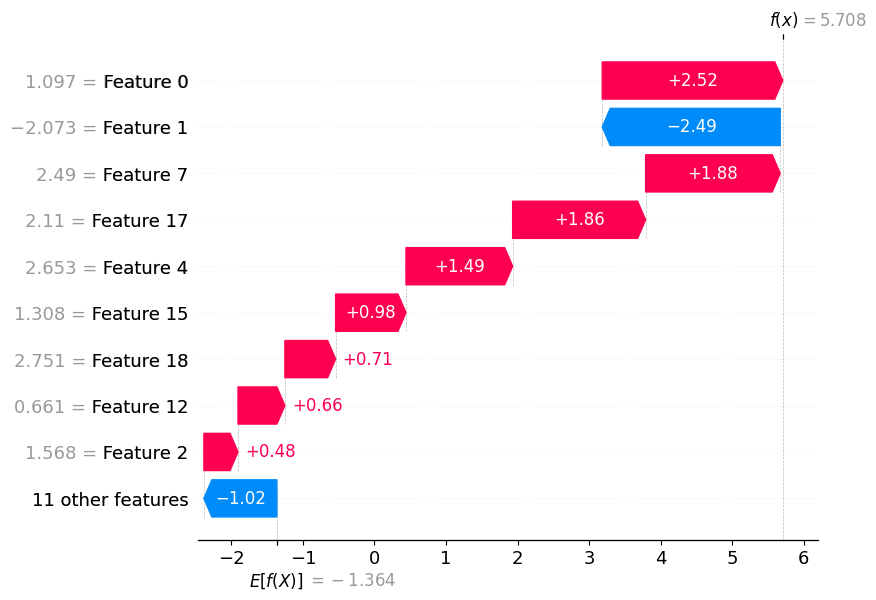


=== [Local Explanation: Plot Only] XGBoost (RandomSearchCV) | 샘플 index=101 ===


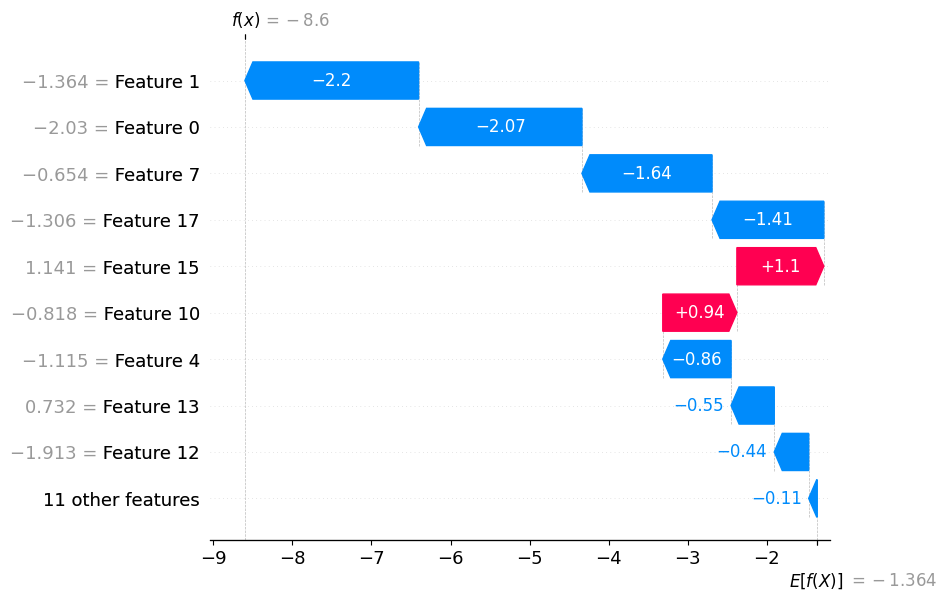


=== [Local Explanation: Plot Only] XGBoost (Optuna TPE) | 샘플 index=236 ===


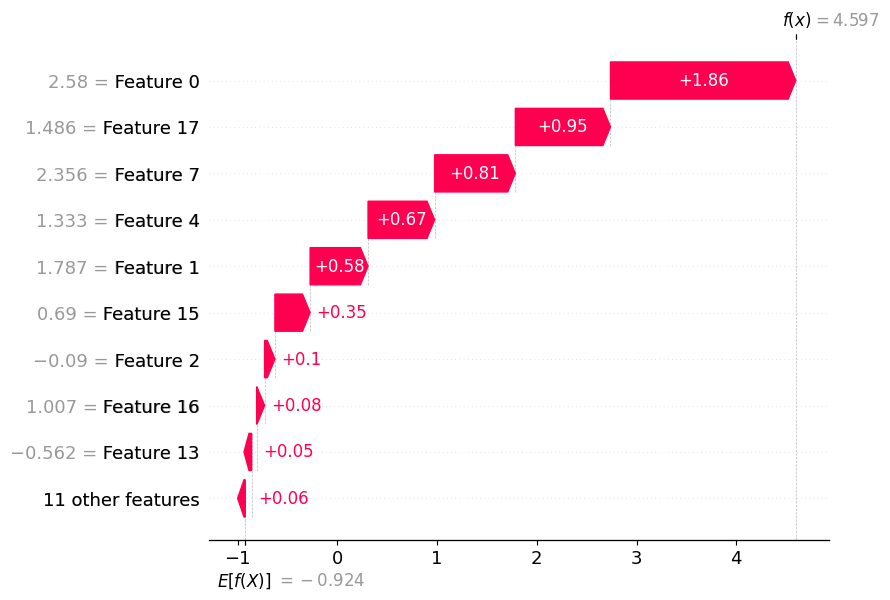


=== [Local Explanation: Plot Only] XGBoost (Optuna TPE) | 샘플 index=297 ===


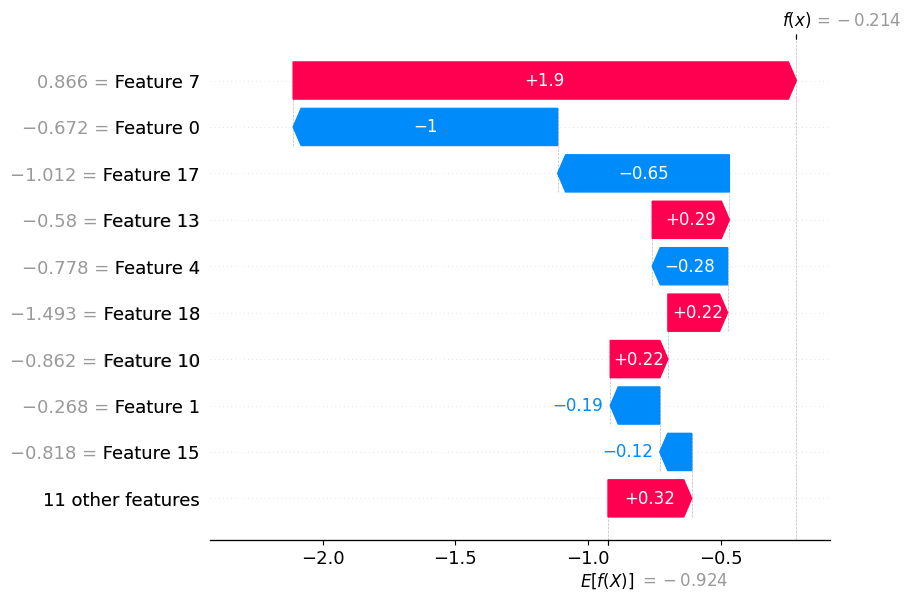


=== [Local Explanation: Plot Only] XGBoost (Optuna TPE) | 샘플 index=0 ===


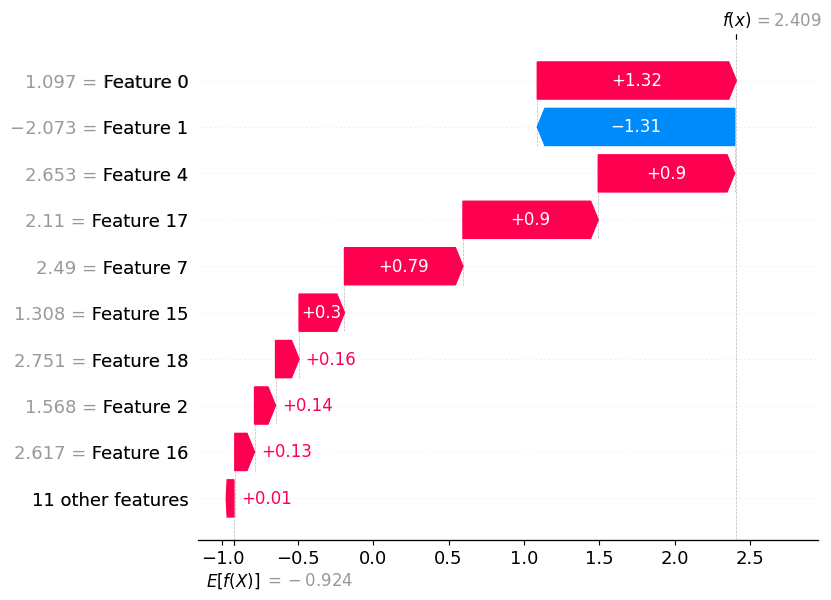


=== [Local Explanation: Plot Only] XGBoost (Optuna TPE) | 샘플 index=101 ===


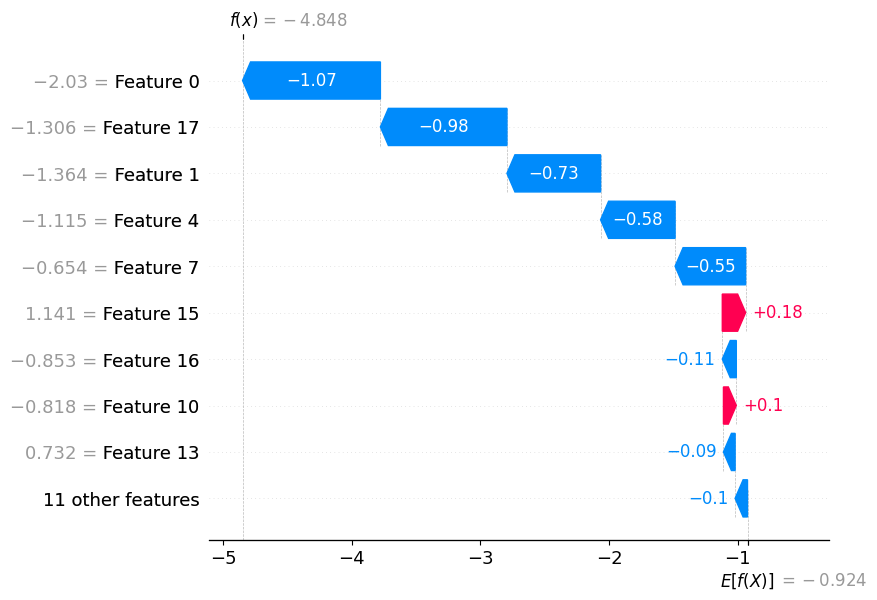

In [ ]:
# 추가 분석 결과 출력
def print_shap_local(shap_values, X, sample_idx=0, top_n=10, model_name="Model"):
    """특정 샘플(Local Explanation) 수치만 출력"""
    print(f"\n=== [Local Explanation: Print Only] {model_name} | 샘플 index={sample_idx} ===")

    base_value = shap_values[sample_idx].base_values
    shap_vals_sample = shap_values[sample_idx].values
    feature_vals_sample = X.iloc[sample_idx]

    df_local = pd.DataFrame({
        "feature": X.columns,
        "feature_value": feature_vals_sample.values,
        "shap_value": shap_vals_sample
    }).sort_values(by="shap_value", key=np.abs, ascending=False)

    print(f"Base value (bias): {base_value}")
    print(f"모델 최종 예측값: {base_value + shap_vals_sample.sum()}")
    print("상위 기여 피처:")
    print(df_local.head(top_n))

def plot_shap_local(shap_values, sample_idx=0, top_n=10, model_name="Model"):
    """특정 샘플(Local Explanation) waterfall plot만 출력"""
    print(f"\n=== [Local Explanation: Plot Only] {model_name} | 샘플 index={sample_idx} ===")
    shap.plots.waterfall(shap_values[sample_idx], max_display=top_n)

sample_indices = [236, 297, 0, 101]  # 선택된 샘플 index들

# ✅ RandomSearchCV 모델
for idx in sample_indices:
    #print_shap_local(shap_values_random, X_processed, sample_idx=idx, top_n=10, model_name="XGBoost (RandomSearchCV)")
    plot_shap_local(shap_values_random, sample_idx=idx, top_n=10, model_name="XGBoost (RandomSearchCV)")

# ✅ Optuna TPE 모델
for idx in sample_indices:
    #print_shap_local(shap_values_optuna, X_processed, sample_idx=idx, top_n=10, model_name="XGBoost (Optuna TPE)")
    plot_shap_local(shap_values_optuna, sample_idx=idx, top_n=10, model_name="XGBoost (Optuna TPE)")


In [ ]:
# 추가 분석 결과 출력
# ✅ RandomSearchCV 모델
for idx in sample_indices:
    print_shap_local(shap_values_random, X_processed, sample_idx=idx, top_n=10, model_name="XGBoost (RandomSearchCV)")
    #plot_shap_local(shap_values_random, sample_idx=idx, top_n=10, model_name="XGBoost (RandomSearchCV)")

# ✅ Optuna TPE 모델
for idx in sample_indices:
    print_shap_local(shap_values_optuna, X_processed, sample_idx=idx, top_n=10, model_name="XGBoost (Optuna TPE)")
    #plot_shap_local(shap_values_optuna, sample_idx=idx, top_n=10, model_name="XGBoost (Optuna TPE)")


=== [Local Explanation: Print Only] XGBoost (RandomSearchCV) | 샘플 index=236 ===
Base value (bias): -1.3638296620842245
모델 최종 예측값: 11.168308656683315
상위 기여 피처:
               feature  feature_value  shap_value
0              radius1       2.579618    3.050362
7              radius2       2.356193    1.902044
17          concavity3       1.486328    1.867596
1             texture1       1.787269    1.627593
4           concavity1       1.333347    1.132707
15         smoothness3       0.689600    1.040196
12     concave_points2       0.870070    0.675197
14  fractal_dimension2      -0.280626    0.540320
18           symmetry3       0.327187    0.536057
10        compactness2       0.176156   -0.492998

=== [Local Explanation: Print Only] XGBoost (RandomSearchCV) | 샘플 index=297 ===
Base value (bias): -1.3638296620842245
모델 최종 예측값: 1.7612848288574072
상위 기여 피처:
               feature  feature_value  shap_value
7              radius2       0.865589    3.118733
0              radius1      -0

- 9-3. Force / Waterfall Plot: version 2
  - Case 1: 샘플 index=236 & 297 (극단적 악성 vs 불확실 케이스)
    - 샘플링 목적
      - 236: 가장 악성일 확률이 높은 케이스 → 모델이 얼마나 확신 있게 악성을 구분하는지 확인
      - 297: 불확실 확률(≈0.85) 케이스 → 모델이 어떤 요인 때문에 혼동하는지 분석
    - RandomSearchCV
      - 236: radius·concavity 관련 피처가 강하게 양수 → 압도적 악성 예측 (logit 11.17)
      - 297: radius2·compactness2는 악성 방향, radius1·concavity3는 양성 방향 → 양성·악성 요인이 충돌 → 불확실한 예측
    - Optuna TPE
      - 236: radius·concavity가 여전히 양수 기여, 다만 크기가 줄어듦 → 악성은 맞지만 더 보수적 예측 (logit 4.60)
      - 297: radius2는 악성↑, 하지만 radius1·concavity3 음수 기여를 더 강하게 반영 → 최종적으로 양성 예측 (logit -0.21)
    - 해석 연결
      - 모델이 극단적 악성 샘플(236)은 두 방식 모두 확신 있게 잡아냄.
      - 불확실 케이스(297)는 RandomSearchCV는 애매하게 악성 쪽으로 기울고, Optuna는 양성 쪽으로 정리 → 튜닝 방법 차이가 불확실성 처리 방식에 반영됨.

  - Case 2: 샘플 index=0 (SHAP 영향력이 가장 큰 케이스)
    - 샘플링 목적
      - SHAP 총합이 가장 큰 샘플 → 모델이 “가장 복잡하게 해석하는” 사례를 분석하기 위함
    - RandomSearchCV
      - radius1(+2.52), concavity3(+1.86), concavity1(+1.49) → 악성↑
      - texture1(-2.49) → 양성↓
      - 결과: 서로 강한 요인이 상충, 결국 악성으로 분류 (logit 5.71)
    - Optuna TPE
      - 기여 패턴은 동일하나 기여 크기 축소 (예: radius1 +1.32, texture1 -1.31)
      - 결과: 여전히 악성 예측이지만 확신도 낮음 (logit 2.41)
    - 해석 연결
      - 이 케이스는 모델 내부에서 가장 많은 변수들이 강하게 작용하는 복잡 패턴.
      - 두 방식 모두 같은 해석(크기·불규칙성↑ = 악성, texture↓ = 양성), 하지만 Optuna는 절대값을 줄여 과도한 확신을 방지.

  - Case 3: 샘플 index=101 (radius1 가장 작은 케이스)
    - 샘플링 목적
      - 도메인 특이 케이스 → “작은 종양 크기(radius1↓)가 어떻게 해석되는가?”를 보기 위함
    - RandomSearchCV
      - radius1(-2.07), texture1(-2.20), concavity3(-1.41) → 모두 양성 기여
      - logit -8.60 → 강한 양성 판정
    - Optuna TPE
      - 같은 변수들이 양성 기여(radius1 -1.07, concavity3 -0.98)
      - 다만 기여 절대값이 줄어 logit -4.85 → 양성은 맞지만 완화된 확신
    - 해석 연결
      - 두 방식 모두 작은 크기(radius)와 낮은 concavity → 양성으로 해석.
      - RandomSearchCV는 극단적 확신, Optuna는 완화된 확신 → 임상적 해석에서 Optuna가 더 현실적일 수 있음.

- 결론
  - Case 1 (236 & 297, 확신 vs 불확실 샘플)에서 모델이 어떻게 극단적 확신/애매한 상황을 처리하는지 확인했고 Optuna는 불확실성을 더 보수적으로 다뤄서 양성으로 기운 해석을 제공했다.
  - Case 2 (0, SHAP 총합 큰 샘플)은 모델이 가장 많은 변수 상호작용을 보이는 복잡 샘플이었는데 확인 결과 RandomSearchCV는 강한 확신, Optuna는 완화된 해석
  - Case 3 (101, 도메인 특이 케이스)로 작은 종양 크기의 양성 패턴 학습 여부 확인했는데 두 모델 모두 양성으로 일관해서 도메인 지식과 부합했다.

# Final Report

SHAP 결과 해석 및 임상 활용 방안

1. Bar Summary Plot 기반 - 전역적 중요도 분석
- 두 모델 모두 radius1(종양 크기)와 concavity(모양 불규칙성)를 핵심 지표로 식별하였고 
- RandomSearchCV는 texture(조직 패턴)까지 균형 있게 반영, Optuna는 concavity를 더 중점적으로 반영.
- 임상 활용 방안
  - 병리 진단 지원 시 “크기(radius)”와 “모양 불규칙성(concavity)”은 암 진단의 주요 기준과 일치하기 때문에 SHAP 기반 해당 전역 해석은 의사·연구자에게 모델이 어떤 병리학적 지표를 중시하는지 투명하게 제시 가능할것으로 생각됨.

2. Beeswarm Plot 기반 - 분포와 방향성 분석
- radius와 concavity 값이 클수록 악성 확률 ↑, 작을수록 ↓ 하다는것은 병리학적 일반 지식과 일치한다.
- 임상 활용 방안
  - “크기가 크고 모양이 불규칙한 환자군”을 조기에 탐지하여 우선 검사 대상자로 분류하는 등 병원 데이터베이스에서 환자군별 위험 패턴 분석 시 활용 가능할것으로 생각된다. 

3. Force / Waterfall Plot 기반 개별 사례 분석 
- 일단 두 모델의 차이를 보면 극단적 확신 샘플(236)은 두 모델이 명확히 악성으로 분류햇지만 불확실 샘플(297)은 RandomSearchCV는 악성 기울임, Optuna는 양성 쪽 보수적 해석을 했다
  - 236 환자는 진단 신뢰성 높아서 다른 분석을 할때도 샘플 데이터로 쓰기 좋을듯. 
  - 두가지 다른 하이퍼파라미터 튜닝 방식이 297와 같이 경계선에있는 환자 판단에 차이를 준것같다. 도메인 반영 추가 분석을 하면 튜닝 특성을 반영하여 297 환자 뿐만아니라 경계 환자의 특성을 뽑아낼수있을것같다.
  - 임상 활용 방안
    - 실제 환자 진료에서 “당신의 종양이 악성으로 분류된 이유는 radius와 concavity 값이 크기 때문입니다.”와 같이 개별 환자 설명 가능성에 따른 Personalized 진료를 제공할수있다 
    - 297 환자같은 불확실 케이스를 fine하게 진료 가능하다.
      - 위에서 불확실 샘플(297)은 RandomSearchCV는 악성 기울임, Optuna는 양성 쪽 보수적 해석을 했었는데, 작은 종양 같은 특이 케이스는 “양성 판정”을 설명하면서도, Optuna처럼 확신 완화된 예측을 제공하면 불필요한 수술·치료를 줄이는 데 기여할수있을것으로 생각된다.

결론
  - 병리학적으로 중요한 지표(radius, concavity)를 SHAP가 재확인해주기때문에 의사나 연구진에게 모델을 설명할때 모델 타당성 설명 가능.
  - radius와 concavity 값이 클수록 악성 확률 ↑, 작을수록 ↓ 하다 같은 척도를 뽑았으니 이를 활용해서 환자군별 위험 패턴을 시각화하여 선별검사 및 예방의학에 활용 가능.
  - 환자 맞춤형 설명을 제공해 불확실 case에 대한 fine한 진료를 보조 가능.